
# Module 2, Assignment 1: Journal Analyzer
Suppose you are tracking journal entries every day. You note the day, your text entry, your mood score, and a category for the day's text entry. You ask Generative AI to write a program for you that analyzes this data. The result is two files: an iPython Notebook file and a csv data file: Journal Mood .ipynb and journal_data.csv

Logistics:
- The program loads and stores the entries from the CSV
- The program calculates overall average mood.
- The program calculates average mood by a specific tag (e.g., "travel", "work").
- There are two visualizations you will see when you run the program. 
- The program uses a Random Forest Classifier to predict the mood category (low, medium, high) from tags.
- The program reports model accuracy and can predict tomorrow’s mood category based on specific tags.

Average mood: 6.75
Average mood on 'travel' days: 7.375


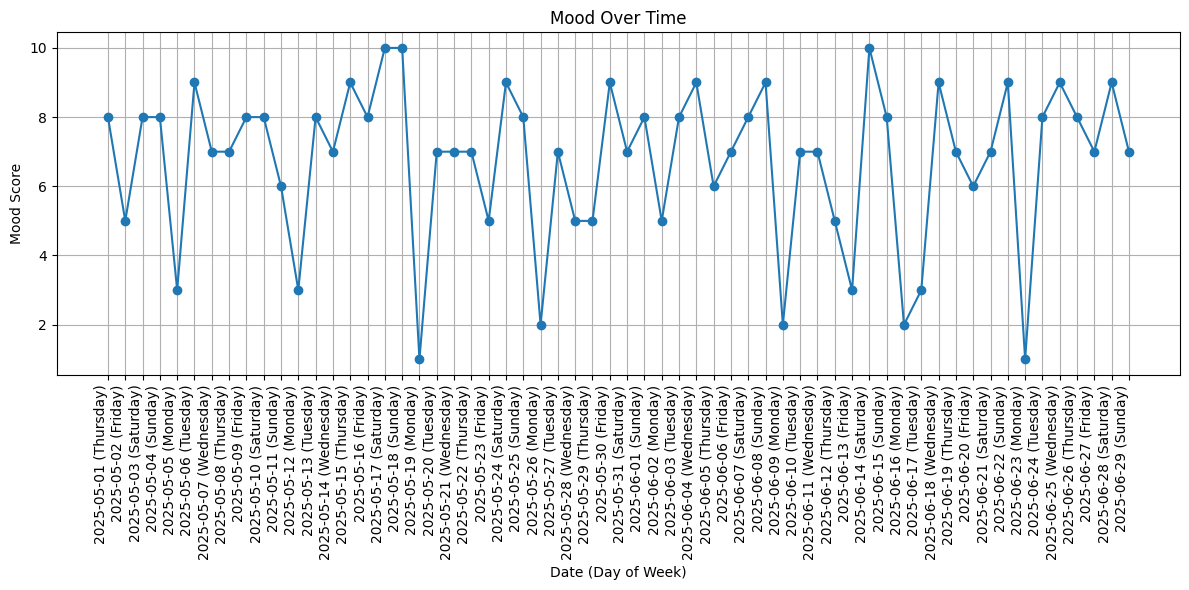

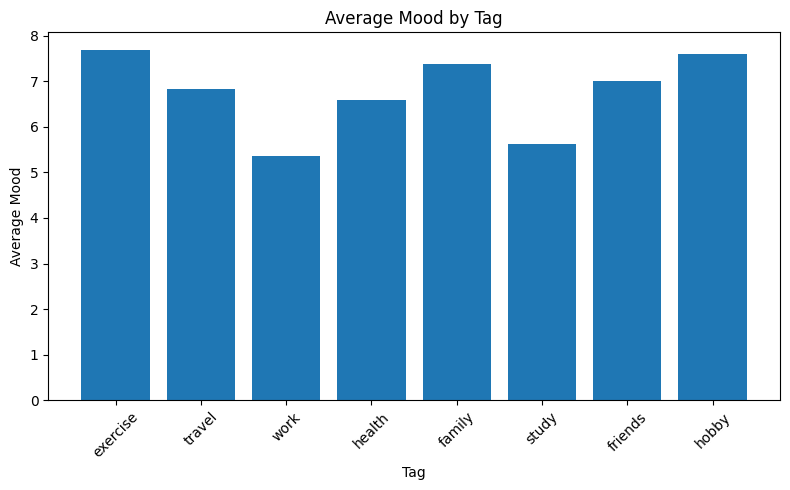

Prediction accuracy: 41.67%
Predicted mood category for tomorrow: high


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


class JournalTracker:
    def __init__(self):
        self.entries = {}  # Nested dictionary: date -> dict with entry, mood, tags, day_of_week

    def add_entry(self, date, entry, mood, tags, day_of_week=None):
        """Add a new journal entry."""
        self.entries[date] = {
            "entry": entry,
            "mood": int(mood),
            "tags": list(tags),
            "day_of_week": day_of_week
        }

    def load_from_csv(self, filename):
        """Load entries from a CSV file into the dictionary.
        Expects columns: date, entry, mood, tags, day_of_week (optional)."""
        df = pd.read_csv(filename)
        for _, row in df.iterrows():
            tags_list = row['tags'].split(";") if isinstance(row['tags'], str) else []
            day_of_week = row['day_of_week'] if 'day_of_week' in df.columns else None
            self.add_entry(row['date'], row['entry'], row['mood'], tags_list, day_of_week)

    def average_mood(self):
        """Calculate average mood."""
        moods = []
        for info in self.entries.values():
            moods.append(info["mood"])
        if moods == []:
            return None
        else:
            return float(np.mean(moods))

    def average_mood_by_tag(self, tag):
        """Calculate average mood for entries with a specific tag."""
        moods = []
        for info in self.entries.values():
            if tag in info["tags"]:
                moods.append(info["mood"])
        if moods == []:
            return None
        else:
            return float(np.mean(moods))

    def plot_mood_over_time(self):
        """Plot mood scores over time, including day of week in x-axis labels."""
        df = pd.DataFrame([
            {"date": date, "mood": info["mood"], "day_of_week": info.get("day_of_week", "")}
            for date, info in self.entries.items()
        ])
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')

        # Create labels with both date and day of week
        df['date_label'] = df['date'].dt.strftime('%Y-%m-%d') + " (" + df['day_of_week'] + ")"

        plt.figure(figsize=(12, 6))
        plt.plot(df['date_label'], df['mood'], marker='o')
        plt.title("Mood Over Time")
        plt.xlabel("Date (Day of Week)")
        plt.ylabel("Mood Score")
        plt.xticks(rotation=90, ha='right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_avg_mood_by_tag(self):
        """Plot average mood by tag."""
        tag_moods = {}
        for info in self.entries.values():
            for tag in info["tags"]:
                tag_moods.setdefault(tag, []).append(info["mood"])
        if not tag_moods:
            print("No tags found.")
            return

        avg_moods = {}
        for tag, scores in tag_moods.items():
            avg_moods[tag] = float(np.mean(scores))

        plt.figure(figsize=(8, 5))
        plt.bar(avg_moods.keys(), avg_moods.values())
        plt.title("Average Mood by Tag")
        plt.xlabel("Tag")
        plt.ylabel("Average Mood")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def predict_mood_category(self, test_size=0.2):
        """Train/test a Random Forest to predict mood category from tags."""
        all_tags_set = set()
        for info in self.entries.values():
            for tag in info["tags"]:
                all_tags_set.add(tag)
        all_tags = sorted(all_tags_set)

        if not all_tags:
            raise ValueError("No tags available to build features.")

        data = []
        labels = []
        for info in self.entries.values():
            features = []
            for tag in all_tags:
                if tag in info["tags"]:
                    features.append(1)
                else:
                    features.append(0)
                    
            data.append(features)
            if info["mood"] < 5:
                labels.append("low")
            elif info["mood"] <= 7:
                labels.append("medium")
            else:
                labels.append("high")

        X = np.array(data)
        y = np.array(labels)

        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=test_size, stratify=y )
        clf = RandomForestClassifier(n_estimators=100)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Prediction accuracy: {accuracy:.2%}")

        return clf, all_tags


def run_tracker():
    tracker = JournalTracker()
    tracker.load_from_csv("journal_data.csv")  # Updated dataset with weekdays

    print("Average mood:", tracker.average_mood())
    print("Average mood on 'travel' days:", tracker.average_mood_by_tag("family"))

    tracker.plot_mood_over_time()
    tracker.plot_avg_mood_by_tag()

    clf, tags_list = tracker.predict_mood_category()

    tomorrow_tags = ["work", "friends"]
    features = []
    for tag in tags_list:
        if tag in tomorrow_tags:
            features.append(1)
        else:
            features.append(0)
            
    predicted_category = clf.predict([features])[0]
    print(f"Predicted mood category for tomorrow: {predicted_category}")

run_tracker()